In [1]:
# Disable TensorFlow debugging info and warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 2: Info and warnings not displayed 

In [2]:
import numpy as np
import sklearn.decomposition
import imblearn
import matplotlib.pyplot as plt
import matplotlib.colors
import pathlib
import tqdm
import annotation, misc, hyspec_cnn, hyspec_io, hyspec_ml  # Local imports

In [3]:
# Parameters
samples_frac = 0.05

In [4]:
# Paths
hyspec_base = pathlib.Path('/media/mha114/Massimal/Vega_Sola/Hyperspectral/20220823/Area/2a_Rrs')
train_val_base = pathlib.Path('/media/mha114/Massimal/Vega_Sola/Hyperspectral/20220823/Area/3a_PCA_TrainValidationSplit')
class_json = train_val_base / 'Training/Annotation/label_classes.json'
pca_dir = pathlib.Path('/media/mha114/Massimal/Vega_Sola/Hyperspectral/20220823/Area/M_PCAModel')
spectra_file = pca_dir / '20220823_Vega_Sola_ExtractedSpectraAndLabels2023-05-27-01h42m12s.npz'
pca_model_path = pca_dir / '20220823_Vega_Sola_PCA-Model.npz'


In [5]:
# Get wavelengths from example hyspec file
example_hyspec_file_path = [path for path in sorted(hyspec_base.rglob('*.hdr'))][0]
_,wl,_,_ = hyspec_io.load_envi_image(str(example_hyspec_file_path),rgb_only=True)

In [6]:
# Load data
with np.load(spectra_file) as npz_files:
    X_raw = npz_files['X']
    y_raw = npz_files['y']

In [7]:
# Remove zero-valued spectra (caused by saturation)
nonzero_spectra_mask = ~np.all(X_raw==0,axis=1)
X = X_raw[nonzero_spectra_mask,:]
y = y_raw[nonzero_spectra_mask]

In [8]:
# Load class names and indices
class_dict = annotation.read_hasty_metadata(class_json)

In [9]:
# Inspect number of samples per class
for class_name, class_index in class_dict.items():
    print(f'{class_name:35} {np.count_nonzero(y==class_index)} samples')

Rock                                205572 samples
Cobble                              106211 samples
Sand                                245730 samples
Mearl bed                           385290 samples
Rockweed                            139784 samples
Kelp                                69648 samples
Brown algae                         274157 samples


In [10]:
# Create custom colormap for classes (including background:0)
custom_cmap = matplotlib.colors.ListedColormap(colors=['black',           # Background
                                                       'hotpink',         # Rock
                                                       'royalblue',       # Cobble
                                                       'darkturquoise',            # Sand
                                                       'magenta',         # Maerl bed
                                                       'seagreen',        # Rockweed
                                                       'darkorange',      # Kelp
                                                       'brown'])          # Brown algae

In [11]:
# Undersample to balance dataset
rus = imblearn.under_sampling.RandomUnderSampler(random_state=0)
X_bal, y_bal = rus.fit_resample(X,y)

In [12]:
# Calculate mean and standard deviation, normalize spectra
X_mean = np.mean(X_bal,axis=0)
X_std = np.std(X_bal,axis=0)
X_norm = (X_bal - X_mean) / X_std

In [13]:
# Create PCA model
pca = sklearn.decomposition.PCA(n_components=30)
_ = pca.fit(X_norm)

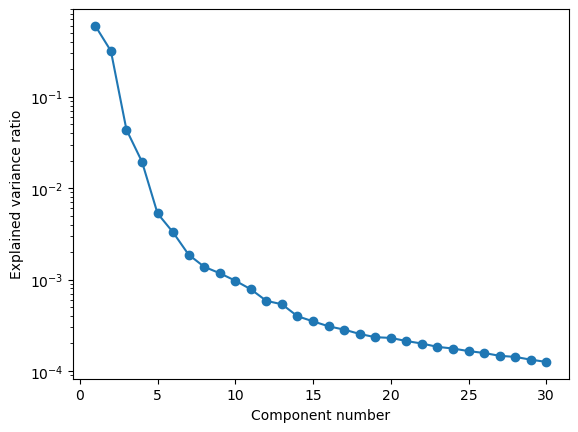

In [14]:
# Plot explained variance ratio
plt.semilogy(np.arange(1,pca.n_components+1),pca.explained_variance_ratio_,'-o')
plt.ylabel('Explained variance ratio')
plt.xlabel('Component number')
plt.show()

In [15]:
print(f'Cumulative explained variance using 8 components: {np.sum(pca.explained_variance_ratio_[0:8])*100} %')

Cumulative explained variance using 8 components: 98.65024690637972 %


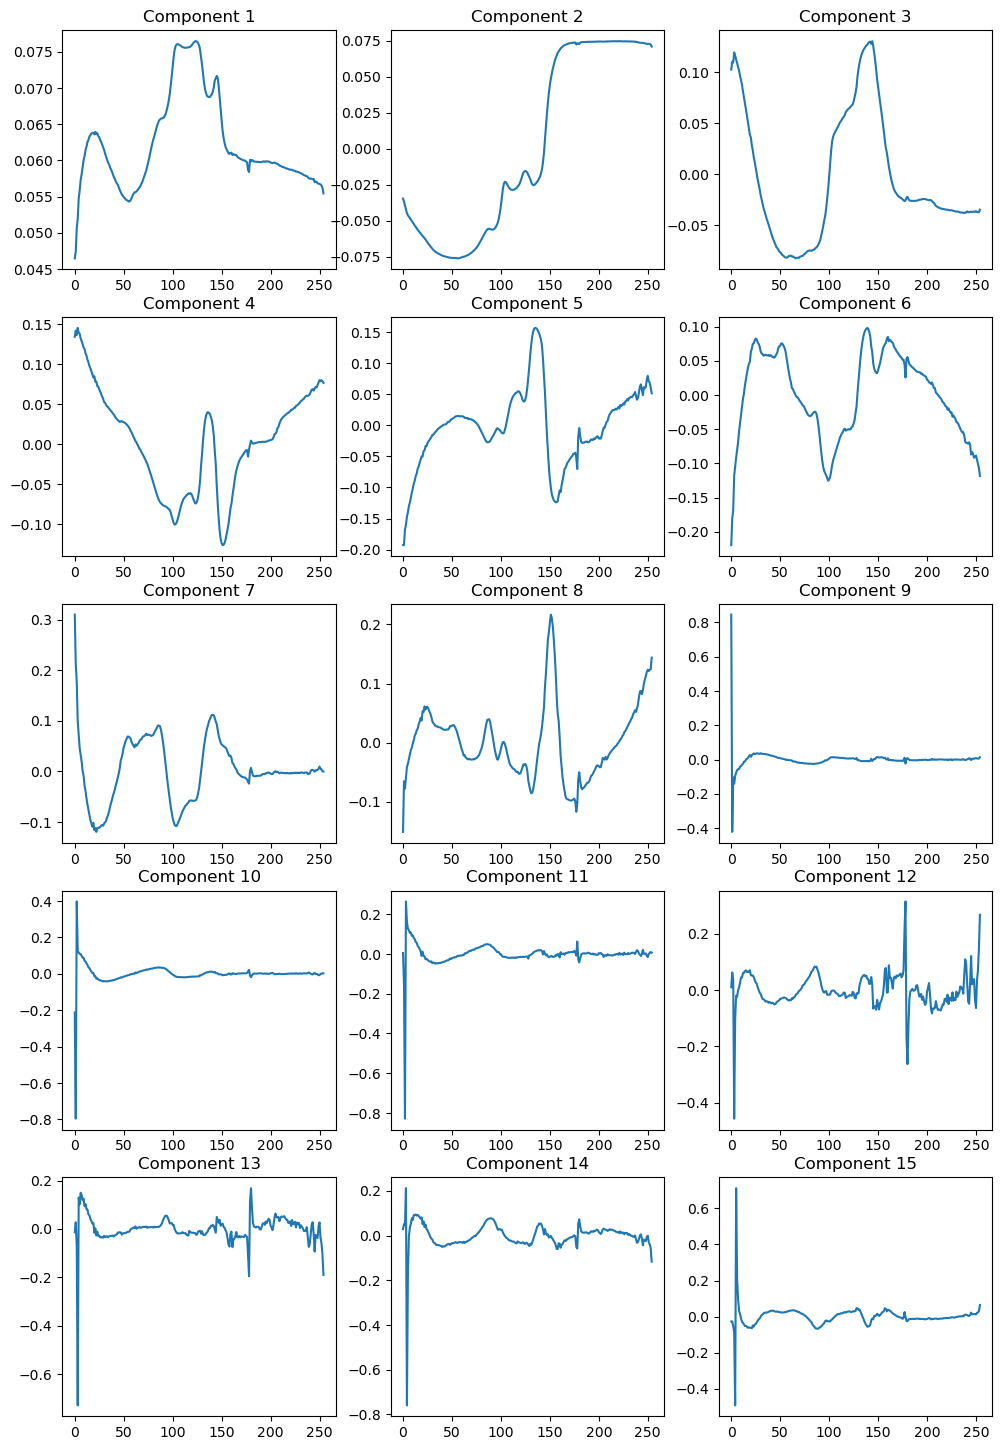

In [16]:
fig, ax = plt.subplots(nrows=5,ncols=3,figsize=(12,18))
for i,component in enumerate(pca.components_[0:15]):
    ax[i//3][i%3].plot(component)
    ax[i//3][i%3].title.set_text(f'Component {i+1}')

In [17]:
#hyspec_ml.save_pca_model(pca,X_bal,npz_filename=pca_model_path,n_components=8)

In [18]:
# Load saved model (check that saving was successful)
W_pca,X_mean_loaded,X_std_loaded = hyspec_ml.read_pca_model(pca_model_path)

In [20]:
assert np.allclose(W_pca,np.transpose(pca.components_[0:8,:]),rtol=1e-2)  # Almost equal - PCA not always the same?
assert np.allclose(X_mean, X_mean_loaded)
assert np.allclose(X_std, X_std_loaded)